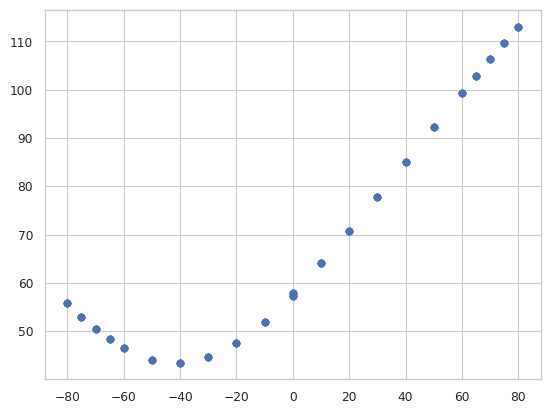

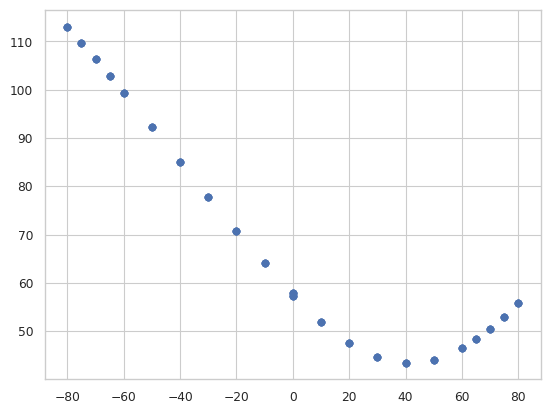

In [74]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read data
data = pd.read_csv("table1csv.csv")

df = data[(data["datayear"] == 2022) & (data["iteration"] == "a")]
df.loc[df["direction"] == "w", "angle"] = -df["angle"]
plt.scatter(df["angle"], df["sundist"])
plt.show()

df = data[(data["datayear"] == 2022) & (data["iteration"] == "a")]
df.loc[df["direction"] == "e", "angle"] = -df["angle"]
plt.scatter(df["angle"], df["sundist"])
plt.show()

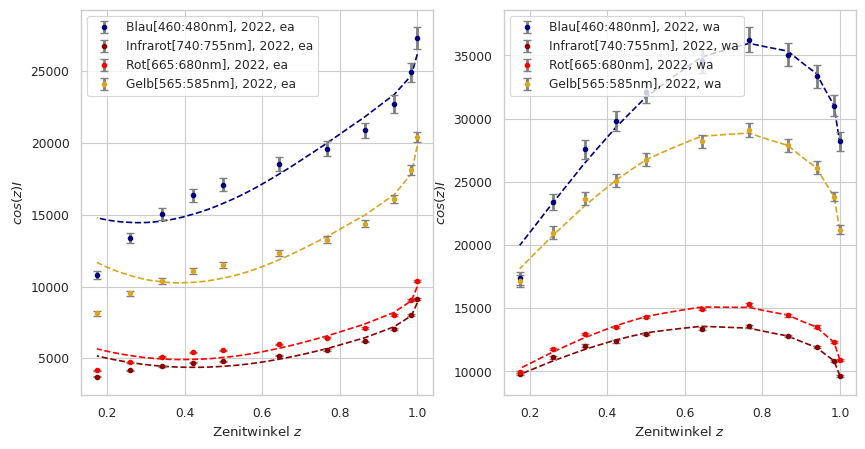

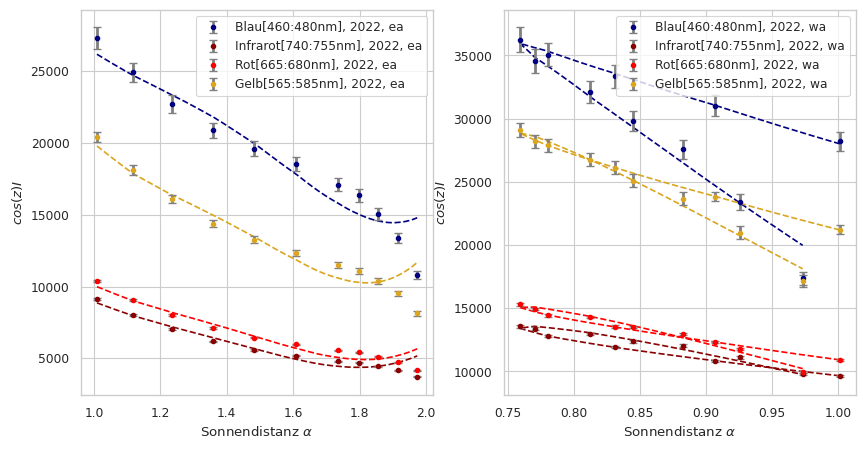

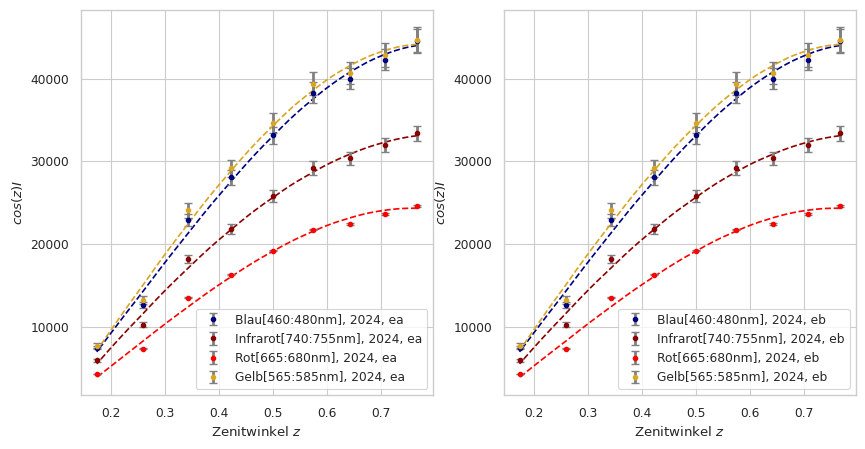

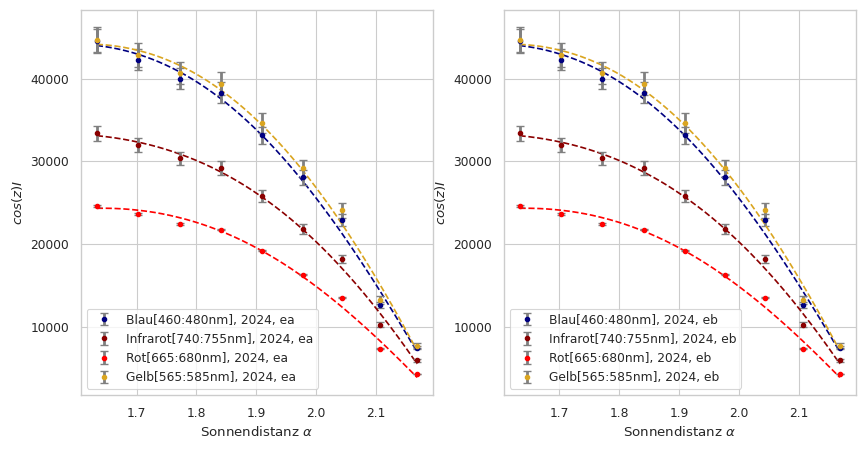

In [91]:
# intensity fit for the different wavelengths, using zenith angle and sun distance (angle)
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# read data
data = pd.read_csv("table1csv.csv")
#data.loc[data["direction"] == "w", "angle"] = -data["angle"] # correct zenith angle

# define fit function to be used
def intensity_fit(p, a0, a1, a2, a3):
    return a0 + a1*np.cos(p[0])**2 + a2*np.cos(p[1])**2*np.cos(p[0]) + a3*np.cos(p[0])

def plot_col_fit(prms, year, iter, dir, ax):
    popts = list(); covmats = list()
    prms_n = prms[(prms["datayear"] == year) & (prms["iteration"] == iter) & (prms["direction"] == dir)]
    
    # dictionary for plot parameters
    dict = {"b": ["navy", "Blau[460:480nm]"], 
        "y": ["goldenrod", "Gelb[565:585nm]"], 
        "r": ["red", "Rot[665:680nm]"], 
        "ir": ["darkred", "Infrarot[740:755nm]"]}

    for c in np.unique(prms_n["color"]):
        # subset to color
        prms_c = prms_n[prms_n["color"] == c]
        # subset input parameters for fit
        prms_in = np.array([np.cos(prms_c["angle"]*np.pi/180), prms_c["sundist"]*np.pi/180])

        # compute fit
        popt, covmat = sp.optimize.curve_fit(intensity_fit, prms_in, prms_in[0]*prms_c["intensity mean"], sigma = prms_c["intensity sd"])
        popts.append(popt); covmats.append(covmat)

        # generate more points for fit
        mid_z = ((prms_in[0] + np.roll(prms_in[0], -1))/2.0)
        z = np.vstack([prms_in[0], mid_z]).flatten('F')[:-1]
        mid_s = ((prms_in[1] + np.roll(prms_in[1], -1))/2.0)
        s = np.vstack([prms_in[1], mid_s]).flatten('F')[:-1]
        for i in range(5):
            mid_z = ((z + np.roll(z, -1))/2.0)
            z = np.vstack([z, mid_z]).flatten('F')[:-1]
            mid_s = ((s + np.roll(s, -1))/2.0)
            s = np.vstack([s, mid_s]).flatten('F')[:-1]

        # choose wether to plot zenith or sundist axis
        if ax == "z": 
            x = prms_in[0]
            x2 = z
            xlab = "Zenitwinkel $z$"
        elif ax == "s": 
            x = prms_in[1]
            x2 = s
            xlab = r"Sonnendistanz $\alpha$"

        # plot points + fit
        lab = str(dict[c][1] + ", " + str(year) + ", " + dir + iter)
        plt.plot(x2, intensity_fit([z, s], popt[0], popt[1], popt[2], popt[3]), color = dict[c][0], ls = "--")
        plt.errorbar(x, prms_in[0]*prms_c["intensity mean"], yerr = prms_in[0]*prms_c["intensity sd"], 
        markersize = 6, fmt = ".",color = dict[c][0], ecolor="gray", elinewidth = 2, capsize = 3, label = lab)
        plt.xlabel(xlab)
        plt.ylabel("$cos(z)I$")
        plt.legend()

    return(popts, covmats)


for y in [2022, 2024]:
    it = "a" if y == 2022 else "b"
    dir = "w" if y == 2022 else "e"
    for ax in ["z", "s"]:
        plt.figure(figsize = (10, 5))
        plt.subplot(121)
        popts, covmats = plot_col_fit(data, y, "a", "e", ax)
        #print fit parameters here
        plt.subplot(122)
        popts, covmats = plot_col_fit(data, y, it, dir, ax)
        #print fit parameters here
        plt.show()


        